<a href="https://colab.research.google.com/github/MeAsghari/MLP-Neural-Network/blob/master/MLP_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 0: Imports and Install📢**

In [ ]:
##pip install
!pip install torchmetrics
!pip install unrar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.6 MB/s eta 0:00:00


In [ ]:
##imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import time

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy

# **Section 1: Load Dataset📑**

## 1-1: Read Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Deep-learning-howsam/mlp/homework

/content/drive/MyDrive/Deep-learning-howsam/mlp/homework


In [ ]:
df = pd.read_csv('dataset/train.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
1,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
2,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
3,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
4,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1


In [ ]:
X = df.drop('DEATH_EVENT' , axis=1).values
y = df['DEATH_EVENT']
X.shape , y.shape

((249, 12), (249,))

##1-2: Train_Test_Split

In [ ]:
x_train , x_valid , y_train , y_valid = train_test_split(X , y , test_size=0.2 , random_state=0 , stratify=y)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(199, 12)
(199,)
(50, 12)
(50,)


##1-3: Preprocess

In [ ]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train.values)

In [ ]:
x_valid = torch.FloatTensor(x_valid)
y_valid = torch.FloatTensor(y_valid.values)

In [ ]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

##1-4: Dataloader

In [ ]:
train_data = TensorDataset(x_train , y_train)
train_loader = DataLoader(train_data , 4 , True)
len(train_loader)

50

In [ ]:
valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False)
len(valid_loader)

5

#**Section 2: Define Model🧠**

##2-1: make your MLP Model

In [ ]:
num_features = 12
num_classes = 1
h1 = 20

model = nn.Sequential(nn.Linear(num_features , h1),
                      nn.ReLU(),

                      nn.Linear(h1 , num_classes),
                      )

In [ ]:
model

Sequential(
  (0): Linear(in_features=12, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=1, bias=True)
)

##2-2: Loss and Optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters() , lr=0.01)

##2-3: Bias for last layer(before train)

In [ ]:
model[-1].bias

Parameter containing:
tensor([0.0296], requires_grad=True)

#**Section 3: Device⚙️**

In [ ]:
divice = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = model.to(divice)

In [ ]:
!nvidia-smi

Sat Nov  4 07:59:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |    635MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#**Section 4: Train Model🤓**

##4-1:Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

##4-1: Torchmetrics

In [ ]:
from torchmetrics import Accuracy

##4-2:Train Loop

In [ ]:
num_epoch = 100

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss = torch.inf

grads_names = []
grads_params = []

since = time.time()
for epoch in range(num_epoch):

  loss_train = AverageMeter()
  acc_train = Accuracy(task='binary').to(divice)

  for i , (inputs , targets) in enumerate(train_loader):
    inputs = inputs.to(divice)
    targets = targets.to(divice)

    outputs = model(inputs)
    loss = loss_fn(outputs , targets.unsqueeze(dim=1))

    loss.backward()
    optimizer.step()
    for name , param in model.named_parameters():
      grads_names.append(name)
      grads_params.append(param.grad)

    optimizer.zero_grad()

    loss_train.update(loss.item())
    acc_train(outputs , targets.unsqueeze(dim=1))

  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='binary').to(divice)

    for i , (inputs , targets) in enumerate(valid_loader):
      inputs = inputs.to(divice)
      targets = targets.to(divice)

      outputs = model(inputs)

      loss = loss_fn(outputs , targets.unsqueeze(dim=1))
      loss_valid.update(loss.item())
      acc_valid(outputs , targets.unsqueeze(dim=1))



  loss_train_hist.append(loss_train.avg)
  loss_valid_hist.append(loss_valid.avg)

  acc_train_hist.append(acc_train.compute().cpu().numpy())
  acc_valid_hist.append(acc_valid.compute().cpu().numpy())

  if loss_valid.avg < best_loss:
    best_loss = loss_valid.avg
    best_epoch = epoch

  if epoch % 2 == 0:
    print(f'Epoch {epoch}')
    print(f'Train: Loss = {loss_train.avg:.4}, Acc = {acc_train.compute():.4}')
    print(f'Valid: Loss = {loss_valid.avg:.4}, Acc = {acc_valid.compute():.4}')
    print()

time_elapsed = time.time() - since

Epoch 0
Train: Loss = 0.6531, Acc = 0.7387
Valid: Loss = 0.656, Acc = 0.64

Epoch 2
Train: Loss = 0.5821, Acc = 0.7286
Valid: Loss = 0.6184, Acc = 0.72

Epoch 4
Train: Loss = 0.533, Acc = 0.7286
Valid: Loss = 0.5918, Acc = 0.72

Epoch 6
Train: Loss = 0.4881, Acc = 0.7538
Valid: Loss = 0.5679, Acc = 0.7

Epoch 8
Train: Loss = 0.4499, Acc = 0.7839
Valid: Loss = 0.5464, Acc = 0.7

Epoch 10
Train: Loss = 0.4161, Acc = 0.8191
Valid: Loss = 0.5283, Acc = 0.72

Epoch 12
Train: Loss = 0.3898, Acc = 0.8342
Valid: Loss = 0.5137, Acc = 0.76

Epoch 14
Train: Loss = 0.366, Acc = 0.8392
Valid: Loss = 0.5039, Acc = 0.76

Epoch 16
Train: Loss = 0.3477, Acc = 0.8593
Valid: Loss = 0.4979, Acc = 0.8

Epoch 18
Train: Loss = 0.334, Acc = 0.8543
Valid: Loss = 0.4947, Acc = 0.8

Epoch 20
Train: Loss = 0.3211, Acc = 0.8643
Valid: Loss = 0.495, Acc = 0.8

Epoch 22
Train: Loss = 0.3114, Acc = 0.8794
Valid: Loss = 0.4969, Acc = 0.8

Epoch 24
Train: Loss = 0.3029, Acc = 0.8794
Valid: Loss = 0.5, Acc = 0.8

Epoch 

#**Section 5: Result📈**

In [ ]:
## Train Time
print(f'train time is: {time_elapsed:.2f}')

train time is: 13.57


##5-1:Plot loss and acc

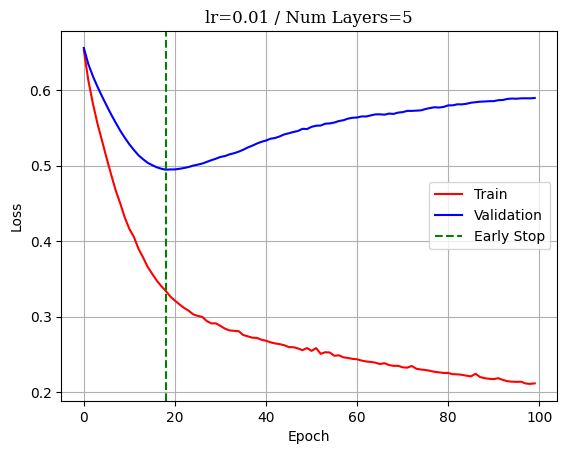

In [ ]:
## plot loss_epoch
plt.plot(range(num_epoch), loss_train_hist, 'r-', label='Train');
plt.plot(range(num_epoch), loss_valid_hist, 'b-', label='Validation');
plt.axvline(best_epoch , ls='--' , c='g' , label='Early Stop')

plt.xlabel('Epoch');
plt.title(f'lr=0.01 / Num Layers=5' , fontfamily='Serif')
plt.ylabel('Loss');
plt.grid(True);
plt.legend();

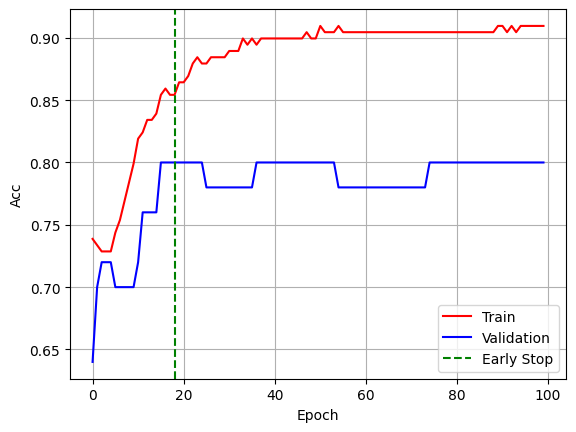

In [ ]:
##plot acc_epoch

plt.plot(range(num_epoch), acc_train_hist, 'r-', label='Train');
plt.plot(range(num_epoch), acc_valid_hist, 'b-', label='Validation');
plt.axvline(best_epoch , ls='--' , c='g' , label='Early Stop');

plt.xlabel('Epoch');
plt.ylabel('Acc');
plt.grid(True);
plt.legend();

##5-2:Count param

In [ ]:
torch.tensor([torch.numel(p) for p in model.parameters()]).sum()

tensor(281)

##5-3: Bias for last layer(after train)

In [ ]:
model[-1].bias

Parameter containing:
tensor([-0.4661], device='cuda:0', requires_grad=True)

#**Section 6: Save and Load Model💰**

##6-1: Save

In [ ]:
torch.save(model , 'model.pth')

##6-2: Load

In [ ]:
my_model = torch.load('model.pth')
my_model

Sequential(
  (0): Linear(in_features=12, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=1, bias=True)
)

#**Section 7: Model Prediction🩺**

##7-1: Use test.csv

In [ ]:
df_test = pd.read_csv('dataset/test .csv')
df_test.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4
1,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8
2,62.0,0,231,0,25,1,253000.0,0.9,140,1,1,10
3,87.0,1,149,0,38,0,262000.0,0.9,140,1,0,14
4,80.0,0,148,1,38,0,149000.0,1.9,144,1,1,23


##7-2 Make predictions.csv file

In [ ]:
test_set = df_test.values
test_set = torch.FloatTensor(test_set)
test_set = (test_set - mu) / std

test_set = test_set.to(divice)

pred = model(test_set)
pred = pred.cpu().detach().numpy()

pred = pred.ravel()
pred = np.where(pred>=0.5 , 1 , 0)
df_pred = pd.DataFrame(pred , columns=['Pred'])
df_pred.to_csv("Prediction",index=False)


#**Section 8: Hyperparam🔨**

##8-1: Change hyperparam

Plot loss_epoch for batch_size:4,8,16

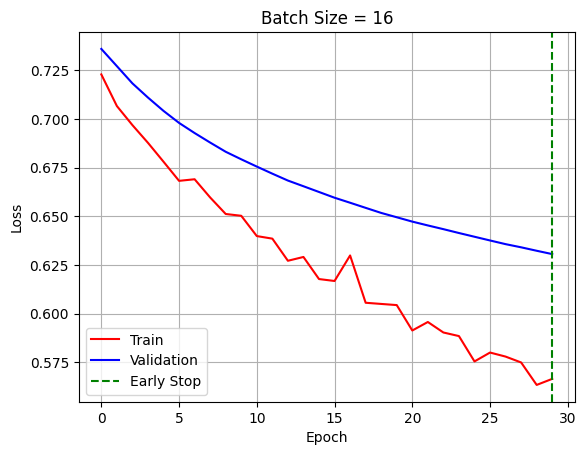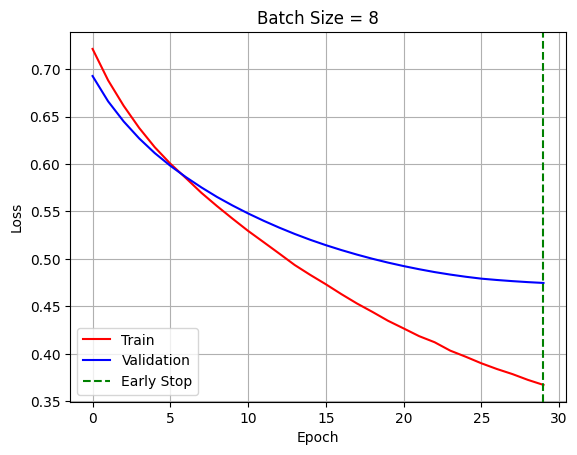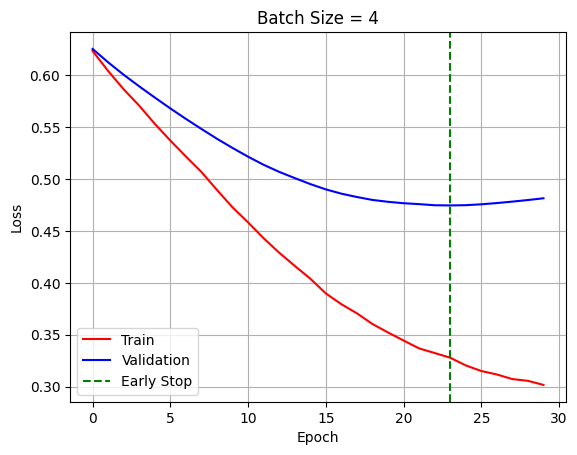

Plot loss_epoch for learningrate:0.1 , 0.01,0.001

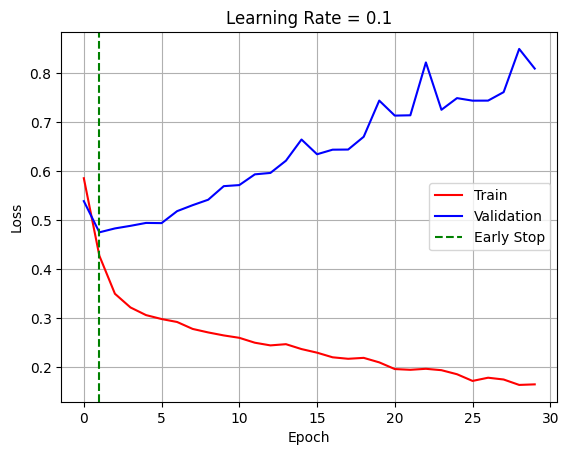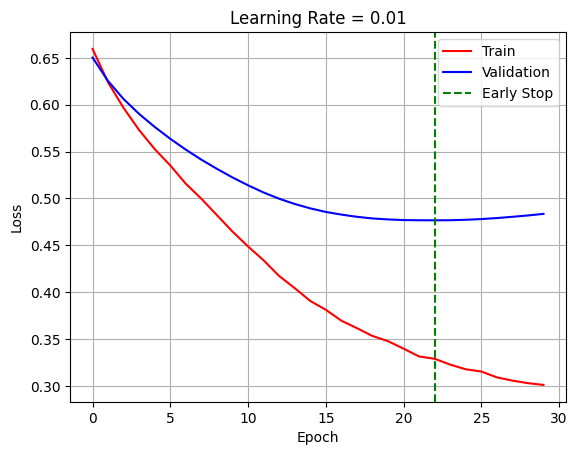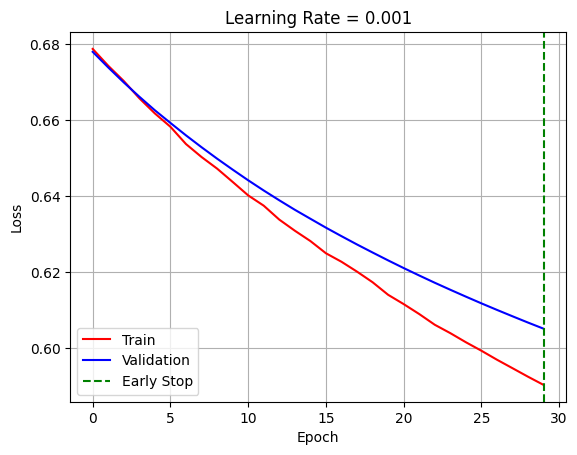

Plot loss_epoch for layer:2,3,4

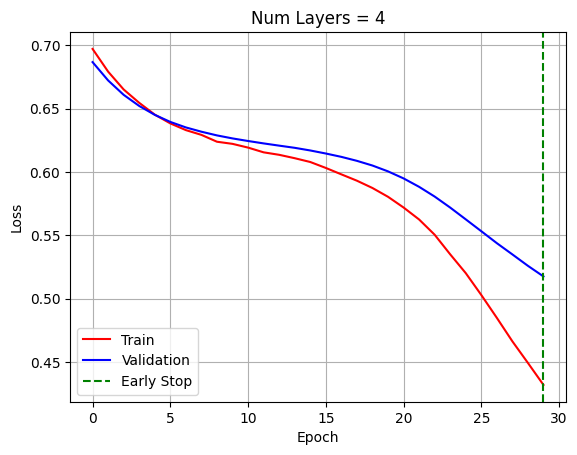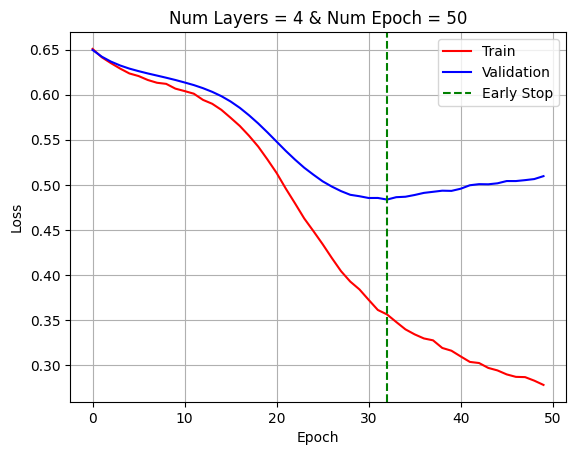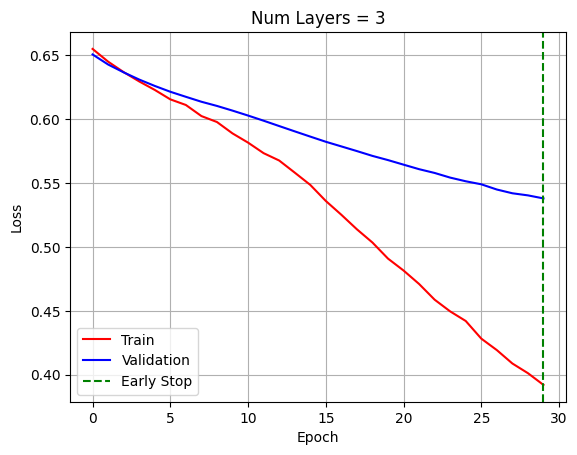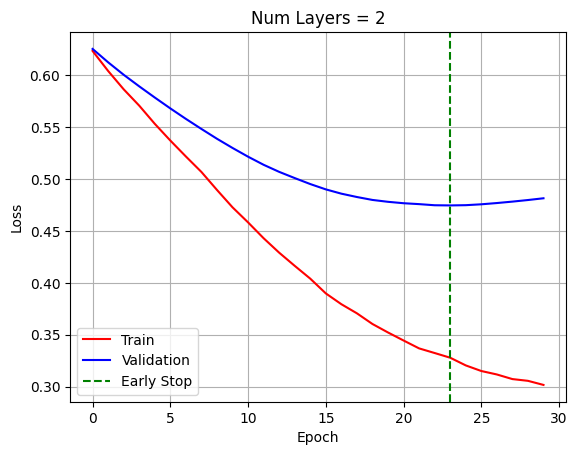

##8-2: Calculate time

Train with CPU

In [ ]:
print(f'Train time with CPU is {2.5631961822509766}')

Train time with CPU is 2.5631961822509766


time GPU VS CPU

In [ ]:
print(f'Train time with CPU is {2.5631961822509766}')
print(f'Train time with GPU is {3.587454319000244}')

Train time with CPU is 2.5631961822509766
Train time with GPU is 3.587454319000244


##8-3:Activation Function

Plot acc_epoch for LeakyReLU and GeLU

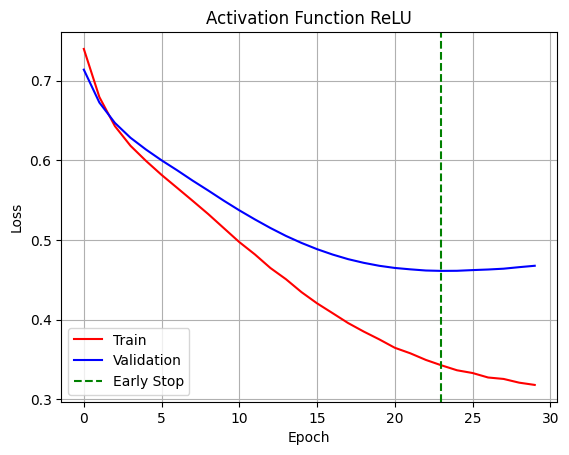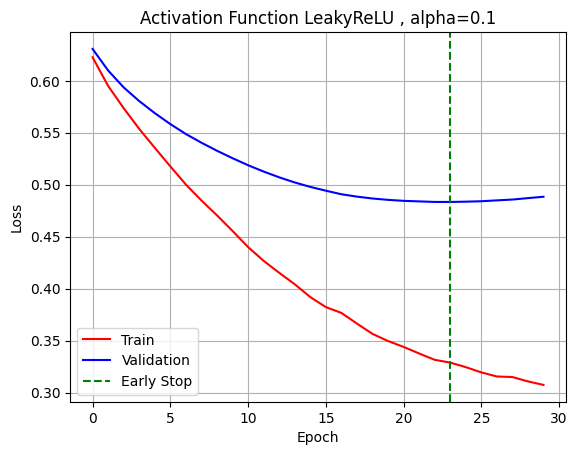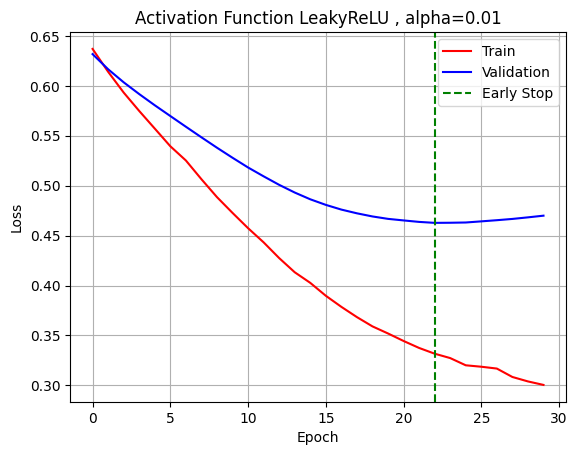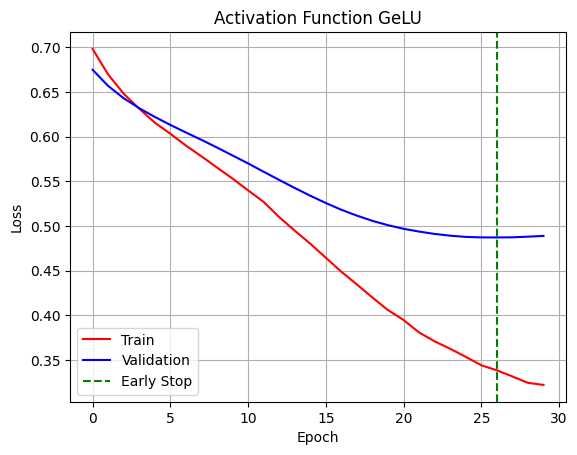